In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Basic Imports

In [35]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [36]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 100

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [37]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [38]:
from scipy.optimize import minimize

### Ansatz State

In [39]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [40]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [41]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [42]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [43]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [44]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [45]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [46]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [47]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [48]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [49]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [50]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=360, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="COBYLA",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [51]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [52]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [53]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values))
    
    return min(sorted(eigen_values))

In [54]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin=3)

## Visualization

In [55]:
approximated_energies = []

In [56]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [57]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies[-NUM_ITERATIONS:])
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [58]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

#### Linear Entangelment

In [59]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

27it [00:01, 13.57it/s]
27it [00:01, 18.82it/s]
27it [00:01, 18.63it/s]
27it [00:01, 14.22it/s]
27it [00:01, 13.71it/s]
27it [00:01, 15.41it/s]
27it [00:01, 17.88it/s]
27it [00:01, 16.52it/s]
27it [00:01, 18.34it/s]
27it [00:01, 16.73it/s]
27it [00:01, 16.65it/s]
27it [00:01, 18.46it/s]
27it [00:01, 18.04it/s]
27it [00:01, 17.47it/s]
27it [00:01, 17.04it/s]
27it [00:01, 18.17it/s]
27it [00:01, 18.25it/s]
27it [00:01, 17.47it/s]
27it [00:01, 17.80it/s]
27it [00:01, 18.38it/s]
27it [00:01, 18.12it/s]
27it [00:01, 18.84it/s]
27it [00:01, 18.20it/s]
27it [00:01, 18.06it/s]
27it [00:01, 15.21it/s]
27it [00:01, 18.35it/s]
27it [00:01, 15.39it/s]
27it [00:01, 15.94it/s]
27it [00:01, 15.76it/s]
27it [00:02, 11.26it/s]
27it [00:02, 10.91it/s]
27it [00:02, 10.21it/s]
27it [00:02, 12.05it/s]
27it [00:02, 12.57it/s]
27it [00:02, 13.09it/s]
27it [00:02, 12.12it/s]
27it [00:02, 12.79it/s]
27it [00:02, 11.33it/s]
27it [00:02, 11.57it/s]
27it [00:02, 13.23it/s]
27it [00:02, 12.64it/s]
27it [00:02, 11.

[264.20016049 285.93988017  86.30409294 329.70029313 206.10851218
 153.68313622 151.94440908 219.28464508 114.55359934  11.03925026
  45.43818421  39.18271219 192.04726838 156.41586141  73.94325842
 201.3017123  145.99556575  49.03432506 107.69080544 159.37355025
 120.96060066 345.89427518 215.20950026 226.91264818  81.96825129
  17.68558579  64.38366717 185.44109314  23.42098415 179.92654049
 208.00425563 252.37675506]


27it [00:01, 14.44it/s]

CPU times: total: 2min 58s
Wall time: 3min 14s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.826561363922414

Approximation Error
0.004605474220703603


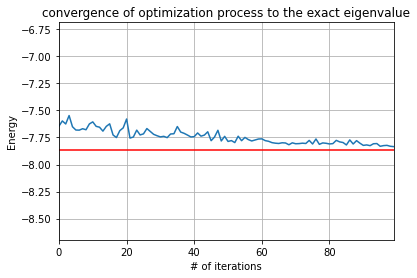

In [60]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

#### Full Entangelment

In [61]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

27it [00:02, 12.42it/s]
27it [00:02, 12.79it/s]
27it [00:02, 11.06it/s]
27it [00:03,  7.31it/s]
27it [00:03,  6.78it/s]
27it [00:02,  9.63it/s]
27it [00:02, 12.20it/s]
27it [00:02, 11.12it/s]
27it [00:02, 10.26it/s]
27it [00:02, 11.94it/s]
27it [00:02, 10.98it/s]
27it [00:02, 10.37it/s]
27it [00:01, 14.37it/s]
27it [00:02, 11.79it/s]
27it [00:02, 13.44it/s]
27it [00:02, 13.17it/s]
27it [00:02, 13.00it/s]
27it [00:01, 13.84it/s]
27it [00:01, 13.89it/s]
27it [00:02, 12.32it/s]
27it [00:02, 10.98it/s]
27it [00:01, 13.90it/s]
27it [00:02, 12.99it/s]
27it [00:02, 11.42it/s]
27it [00:02, 11.90it/s]
27it [00:02, 12.11it/s]
27it [00:01, 13.79it/s]
27it [00:01, 13.76it/s]
27it [00:02, 13.22it/s]
27it [00:02, 11.71it/s]
27it [00:02, 13.16it/s]
27it [00:02, 12.88it/s]
27it [00:01, 14.41it/s]
27it [00:02, 12.78it/s]
27it [00:01, 15.12it/s]
27it [00:02, 12.10it/s]
27it [00:02, 12.63it/s]
27it [00:02, 11.63it/s]
27it [00:02, 11.29it/s]
27it [00:02, 10.26it/s]
27it [00:02, 11.54it/s]
27it [00:02, 12.

[157.31429885 189.21651972  95.12954523 222.50911231 359.01607923
 218.3924018   52.03890025 236.72620361 299.36727455 106.95144285
 153.74185452  25.38047746  59.12566693 269.50527648  12.19279262
 278.19014888 212.34955352 102.89130696 231.69430146 316.13430954
  94.88248781  22.88119727 353.76285495  72.85253901 106.88890808
  40.36042751 154.3933523  205.00122286  71.76985947  79.06026072
 320.7010062  273.24599806]


27it [00:02,  9.44it/s]

CPU times: total: 3min 34s
Wall time: 3min 58s


[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.724395650995989

Approximation Error
0.017599072129241066


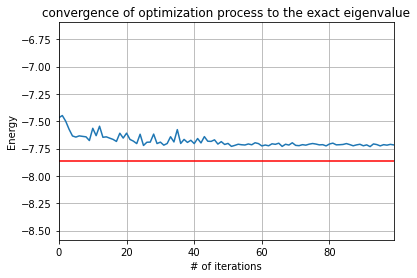

In [62]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [63]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

#### Linear Entangelment

In [64]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

15it [00:01,  9.27it/s]
15it [00:01, 10.00it/s]
15it [00:01, 10.83it/s]
15it [00:01, 11.27it/s]
15it [00:01, 10.67it/s]
15it [00:01, 11.08it/s]
15it [00:01, 11.05it/s]
15it [00:01, 11.15it/s]
15it [00:01, 10.90it/s]
15it [00:01, 11.40it/s]
15it [00:01, 10.17it/s]
15it [00:01, 11.67it/s]
15it [00:01, 12.33it/s]
15it [00:01, 11.98it/s]
15it [00:01,  9.68it/s]
15it [00:01, 11.27it/s]
15it [00:01,  9.52it/s]
15it [00:01, 11.72it/s]
15it [00:01, 14.01it/s]
15it [00:01, 10.74it/s]
15it [00:01, 11.22it/s]
15it [00:01, 12.05it/s]
15it [00:01, 13.08it/s]
15it [00:00, 15.04it/s]
15it [00:01, 14.46it/s]
15it [00:01, 14.41it/s]
15it [00:01, 12.32it/s]
15it [00:01, 14.13it/s]
15it [00:01, 13.41it/s]
15it [00:01, 11.97it/s]
15it [00:01, 13.52it/s]
15it [00:01, 11.79it/s]
15it [00:01, 12.37it/s]
15it [00:01, 10.89it/s]
15it [00:01,  7.91it/s]
15it [00:01, 10.77it/s]
15it [00:01,  9.60it/s]
15it [00:01, 10.53it/s]
15it [00:01,  9.03it/s]
15it [00:01,  9.72it/s]
15it [00:01,  9.17it/s]
15it [00:01,  8.

[201.0291063  333.75700845 267.23082525 110.51323688 175.67770716
 256.01712147 187.51470475 348.12435546 122.49171846 359.84916751
  12.41320313 316.25893568  95.31286932 135.50689825 267.79699899
 265.04394385 193.98145651 140.55121323 169.65348826 358.29394135
 173.64059073 281.37072893 111.23677845 358.04132753 290.23145572
 192.79813543 200.34257298 312.13964415 103.97507653 205.40236689
 216.67175657 251.73609582]


15it [00:01,  8.37it/s]

CPU times: total: 2min 5s
Wall time: 2min 20s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.1282114439588777

Approximation Error
0.3925447628314147


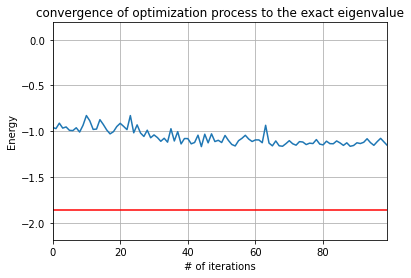

In [65]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [66]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

15it [00:01,  8.01it/s]
15it [00:01,  7.79it/s]
15it [00:01,  7.97it/s]
15it [00:01,  8.70it/s]
15it [00:01,  8.13it/s]
15it [00:01,  8.44it/s]
15it [00:01,  9.87it/s]
15it [00:01, 10.07it/s]
15it [00:01, 10.69it/s]
15it [00:01,  7.91it/s]
15it [00:01,  8.16it/s]
15it [00:01,  8.02it/s]
15it [00:01,  9.59it/s]
15it [00:01,  9.14it/s]
15it [00:02,  7.48it/s]
15it [00:01,  9.15it/s]
15it [00:01,  8.90it/s]
15it [00:01,  8.17it/s]
15it [00:01,  7.64it/s]
15it [00:01,  7.53it/s]
15it [00:01,  7.84it/s]
15it [00:01,  7.91it/s]
15it [00:01,  8.64it/s]
15it [00:01,  9.71it/s]
15it [00:01,  8.48it/s]
15it [00:01,  7.68it/s]
15it [00:01, 10.22it/s]
15it [00:01,  7.99it/s]
15it [00:01,  8.91it/s]
15it [00:01, 10.10it/s]
15it [00:01,  8.59it/s]
15it [00:01,  8.96it/s]
15it [00:01,  9.83it/s]
15it [00:01,  7.59it/s]
15it [00:01,  8.06it/s]
15it [00:01,  8.28it/s]
15it [00:01, 10.47it/s]
15it [00:01,  8.86it/s]
15it [00:01,  8.73it/s]
15it [00:01,  8.34it/s]
15it [00:01,  8.35it/s]
15it [00:01,  9.

[267.13476128 257.47871837   5.49780499  12.31332627 129.67485178
 269.13936457 228.56789227  38.28250423  30.77882891 321.13592291
 166.90301899 358.38848233 186.83155359 314.45889748 283.11142555
   6.43413453  53.3034124   58.7365398  227.65647154 246.43863104
  57.06619744 153.01821153 116.38824544  56.54010904  52.76995317
 129.34052552 213.99358894  83.30109394 243.89673788   4.37720364
  43.45054332   1.52094246]


15it [00:01,  8.27it/s]

CPU times: total: 2min 36s
Wall time: 3min 5s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.5420738102925051

Approximation Error
0.1697116554006156


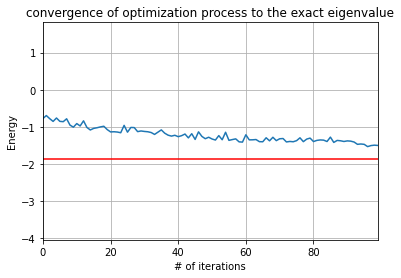

In [67]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [68]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

#### Linear Entangelment

In [69]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

11it [00:01,  8.11it/s]
11it [00:01,  7.65it/s]
11it [00:01,  8.47it/s]
11it [00:01,  6.55it/s]
11it [00:01,  8.18it/s]
11it [00:01,  9.05it/s]
11it [00:01,  9.22it/s]
11it [00:01,  8.21it/s]
11it [00:01,  7.97it/s]
11it [00:01,  9.35it/s]
11it [00:01,  9.42it/s]
11it [00:01,  8.52it/s]
11it [00:01,  9.27it/s]
11it [00:01,  9.23it/s]
11it [00:01,  8.40it/s]
11it [00:01,  8.26it/s]
11it [00:01,  7.87it/s]
11it [00:01,  9.35it/s]
11it [00:01,  8.26it/s]
11it [00:01,  8.92it/s]
11it [00:01,  9.16it/s]
11it [00:01,  8.48it/s]
11it [00:01,  6.65it/s]
11it [00:01,  7.56it/s]
11it [00:01,  7.62it/s]
11it [00:01,  9.02it/s]
11it [00:01,  8.13it/s]
11it [00:01,  7.31it/s]
11it [00:01,  6.16it/s]
11it [00:01,  8.25it/s]
11it [00:01,  8.28it/s]
11it [00:01,  9.39it/s]
11it [00:01,  8.28it/s]
11it [00:01,  8.83it/s]
11it [00:01,  8.80it/s]
11it [00:01,  7.81it/s]
11it [00:01,  8.52it/s]
11it [00:01,  8.69it/s]
11it [00:01,  8.96it/s]
11it [00:01,  8.43it/s]
11it [00:01,  7.57it/s]
11it [00:01,  9.

[2.61657284e+02 2.97989244e+01 2.17044610e+02 2.55270598e+02
 3.43679728e+02 1.32752340e+02 6.58867042e+00 4.72394299e+00
 1.76724174e+01 8.74710458e+01 1.17857388e+02 2.47986463e+02
 1.76096869e+02 2.07786533e+00 6.16224786e+01 3.10163659e+02
 1.14981930e+02 1.53617409e+02 1.27082364e+02 2.90401345e+02
 2.99173662e+02 1.54210914e+01 2.22820247e+02 2.54143922e+02
 1.11650857e+02 2.38513092e+02 2.50334005e-01 3.50124357e+02
 1.03950597e+02 2.25367527e+02 3.50826828e+02 3.74323850e+01]


11it [00:01,  5.86it/s]

CPU times: total: 1min 59s
Wall time: 2min 25s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-0.9840686447126921

Approximation Error
0.5078390889439324


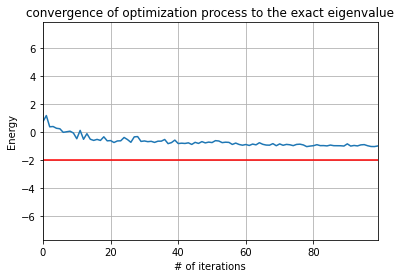

In [70]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [71]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

11it [00:01,  7.17it/s]
11it [00:01,  7.21it/s]
11it [00:01,  6.76it/s]
11it [00:01,  6.00it/s]
11it [00:01,  6.80it/s]
11it [00:01,  7.20it/s]
11it [00:01,  8.21it/s]
11it [00:01,  7.74it/s]
11it [00:01,  6.77it/s]
11it [00:01,  6.04it/s]
11it [00:01,  5.87it/s]
11it [00:01,  6.03it/s]
11it [00:02,  5.28it/s]
11it [00:01,  5.92it/s]
11it [00:01,  6.12it/s]
11it [00:01,  6.32it/s]
11it [00:01,  6.10it/s]
11it [00:01,  6.54it/s]
11it [00:01,  6.43it/s]
11it [00:01,  6.62it/s]
11it [00:01,  7.17it/s]
11it [00:01,  7.22it/s]
11it [00:01,  6.10it/s]
11it [00:01,  6.49it/s]
11it [00:01,  6.92it/s]
11it [00:02,  4.93it/s]
11it [00:01,  5.82it/s]
11it [00:01,  6.37it/s]
11it [00:01,  6.13it/s]
11it [00:01,  6.86it/s]
11it [00:01,  6.91it/s]
11it [00:01,  6.36it/s]
11it [00:01,  6.90it/s]
11it [00:01,  7.07it/s]
11it [00:01,  6.27it/s]
11it [00:01,  6.69it/s]
11it [00:01,  6.47it/s]
11it [00:01,  6.94it/s]
11it [00:01,  7.35it/s]
11it [00:01,  6.60it/s]
11it [00:01,  7.40it/s]
11it [00:01,  6.

[112.90281921 152.46471973  97.40817719 170.11778732 306.84113992
  64.06527505 315.69131589 115.57194952 131.79586734 292.81450705
  22.01077827 321.69206027 324.17175386  37.04459401 227.7404291
  43.68931051 100.01236559 255.81652369 135.89996682 100.46237002
  24.36499909 203.9990932  172.63528136 320.69731628  58.45643732
  81.00428229  90.43392023 231.24676698 178.04038665 103.13622601
 116.05062029  51.17669563]


11it [00:01,  6.85it/s]

CPU times: total: 2min 8s
Wall time: 2min 55s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-1.8673692559360267

Approximation Error
0.06607515723876144


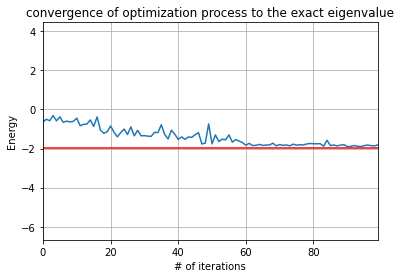

In [72]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [73]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 100

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [74]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

#### Linear Entangelment

In [75]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

7it [00:00,  9.01it/s]
7it [00:00,  8.17it/s]
7it [00:00,  8.16it/s]
7it [00:00,  9.39it/s]
7it [00:00,  8.32it/s]
7it [00:00,  7.87it/s]
7it [00:00,  7.65it/s]
7it [00:00,  8.09it/s]
7it [00:00,  7.66it/s]
7it [00:00,  8.52it/s]
7it [00:00, 10.24it/s]
7it [00:00,  8.48it/s]
7it [00:00,  7.95it/s]
7it [00:00,  8.45it/s]
7it [00:00,  7.26it/s]
7it [00:00,  8.40it/s]
7it [00:00,  8.11it/s]
7it [00:00,  7.99it/s]
7it [00:00,  9.02it/s]
7it [00:00,  8.85it/s]
7it [00:00, 10.41it/s]
7it [00:00,  9.08it/s]
7it [00:00,  8.17it/s]
7it [00:00,  8.24it/s]
7it [00:00,  9.95it/s]
7it [00:00,  9.27it/s]
7it [00:00,  9.19it/s]
7it [00:00,  9.08it/s]
7it [00:00,  9.18it/s]
7it [00:00,  8.54it/s]
7it [00:00, 10.28it/s]
7it [00:00,  9.06it/s]
7it [00:00,  9.00it/s]
7it [00:00,  8.26it/s]
7it [00:01,  5.24it/s]
7it [00:00,  7.63it/s]
7it [00:00,  7.67it/s]
7it [00:01,  6.33it/s]
7it [00:00,  7.61it/s]
7it [00:00,  8.90it/s]
7it [00:00,  7.83it/s]
7it [00:00,  7.80it/s]
7it [00:00,  8.22it/s]
7it [00:01,

[328.42563171 340.82560197 149.50785515 247.20059177 199.19419955
  85.1750821  130.356183   337.03802371  30.83638439 322.75121352
 305.26652266 155.51690664  54.62569827 250.91302713  32.16150845
 321.73226298 294.32968456 227.14114451 177.02260325 303.82215351
 284.82359262 354.78928399 274.10173468  23.49394645]


7it [00:00,  9.03it/s]

CPU times: total: 1min 3s
Wall time: 1min 27s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.9022357673125379

Approximation Error
0.20347167179254427


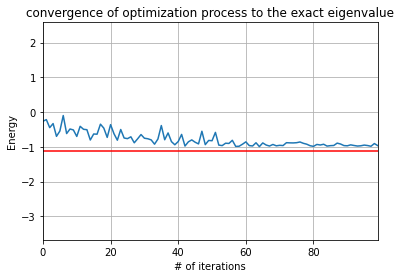

In [76]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [77]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

7it [00:00,  8.92it/s]
7it [00:00,  9.00it/s]
7it [00:00,  8.52it/s]
7it [00:00,  8.86it/s]
7it [00:00,  9.79it/s]
7it [00:00,  9.28it/s]
7it [00:00,  9.41it/s]
7it [00:00,  7.79it/s]
7it [00:00,  9.11it/s]
7it [00:00,  7.97it/s]
7it [00:00,  7.25it/s]
7it [00:00,  7.68it/s]
7it [00:00,  7.56it/s]
7it [00:01,  5.49it/s]
7it [00:00,  8.17it/s]
7it [00:00,  9.25it/s]
7it [00:00,  7.28it/s]
7it [00:00,  7.32it/s]
7it [00:00,  7.31it/s]
7it [00:00,  8.44it/s]
7it [00:00,  7.82it/s]
7it [00:00,  8.49it/s]
7it [00:00,  7.97it/s]
7it [00:00,  7.62it/s]
7it [00:00,  8.97it/s]
7it [00:00,  8.98it/s]
7it [00:00,  7.88it/s]
7it [00:00, 10.16it/s]
7it [00:00,  8.78it/s]
7it [00:00,  9.07it/s]
7it [00:00,  8.94it/s]
7it [00:00,  8.51it/s]
7it [00:00, 10.16it/s]
7it [00:00,  7.74it/s]
7it [00:00,  8.67it/s]
7it [00:00,  7.91it/s]
7it [00:00,  8.83it/s]
7it [00:00,  8.54it/s]
7it [00:00,  9.05it/s]
7it [00:00,  7.85it/s]
7it [00:00,  7.55it/s]
7it [00:00,  7.94it/s]
7it [00:01,  6.66it/s]
7it [00:01,

[229.73270244 261.34498285 252.87563549 322.93397937  93.64053935
 320.7573359   30.60256749 163.19467331 208.70982654 215.99017357
  95.54820949 313.25089727  46.83327533 120.10045141 150.85097496
 182.79999196 231.75890993 357.48763881  53.88520293 281.85502872
 313.91501733 347.39195395 317.53895761 314.93315433]


7it [00:00,  7.85it/s]

CPU times: total: 1min 4s
Wall time: 1min 32s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-1.0150086320321505

Approximation Error
0.10391146296836636


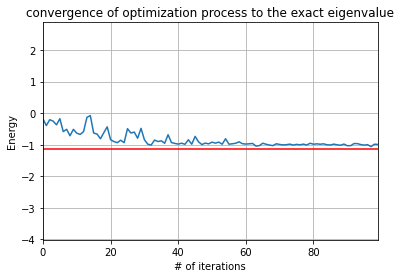

In [78]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [79]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 100

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [80]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

#### Linear Entangelment

In [81]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

3it [00:00,  8.42it/s]
3it [00:00,  7.56it/s]
3it [00:00, 10.64it/s]
3it [00:00,  8.00it/s]
3it [00:00,  9.49it/s]
3it [00:00,  7.92it/s]
3it [00:00,  8.90it/s]
3it [00:00,  7.68it/s]
3it [00:00,  8.63it/s]
3it [00:00,  5.83it/s]
3it [00:00, 10.66it/s]
3it [00:00, 11.13it/s]
3it [00:00, 10.68it/s]
3it [00:00, 12.74it/s]
3it [00:00,  8.81it/s]
3it [00:00, 11.09it/s]
3it [00:00, 12.00it/s]
3it [00:00,  7.52it/s]
3it [00:00, 15.19it/s]
3it [00:00, 10.42it/s]
3it [00:00,  8.64it/s]
3it [00:00, 13.76it/s]
3it [00:00, 12.88it/s]
3it [00:00,  6.73it/s]
3it [00:00, 11.49it/s]
3it [00:00,  6.57it/s]
3it [00:00, 10.05it/s]
3it [00:00,  6.36it/s]
3it [00:00, 11.29it/s]
3it [00:00,  7.02it/s]
3it [00:00,  6.81it/s]
3it [00:00,  8.88it/s]
3it [00:00, 13.27it/s]
3it [00:00,  8.70it/s]
3it [00:00,  9.40it/s]
3it [00:00,  8.72it/s]
3it [00:00, 10.30it/s]
3it [00:00, 11.56it/s]
3it [00:00,  8.12it/s]
3it [00:00,  5.59it/s]
3it [00:00, 11.26it/s]
3it [00:00, 13.42it/s]
3it [00:00, 12.20it/s]
3it [00:00,

[197.50402063 130.65062361  77.38803707 272.90944373 316.07411946
 335.33041411 332.51781387 192.50744746 222.35943449  29.4184496
 175.08396082 226.13394117 334.50176147 143.4880231  149.27817432
 251.98202643]


3it [00:00, 12.30it/s]

CPU times: total: 20.1 s
Wall time: 33.2 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-0.8890640610143257

Approximation Error
0.13428809249165494


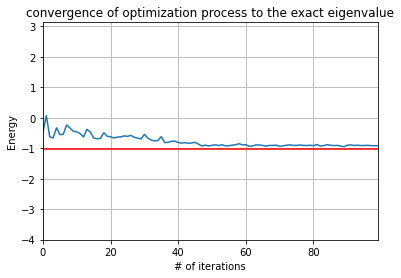

In [82]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [83]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

3it [00:00, 11.83it/s]
3it [00:00,  8.57it/s]
3it [00:00, 12.58it/s]
3it [00:00, 10.96it/s]
3it [00:00, 13.67it/s]
3it [00:00, 13.27it/s]
3it [00:00,  9.23it/s]
3it [00:00, 11.25it/s]
3it [00:00, 13.52it/s]
3it [00:00, 10.63it/s]
3it [00:00, 11.75it/s]
3it [00:00, 16.00it/s]
3it [00:00,  7.96it/s]
3it [00:00, 10.41it/s]
3it [00:00, 13.10it/s]
3it [00:00,  6.62it/s]
3it [00:00,  8.66it/s]
3it [00:00,  6.05it/s]
3it [00:00, 12.41it/s]
3it [00:00,  9.10it/s]
3it [00:00, 12.03it/s]
3it [00:00, 10.97it/s]
3it [00:00,  8.37it/s]
3it [00:00,  9.78it/s]
3it [00:00, 13.78it/s]
3it [00:00,  8.36it/s]
3it [00:00, 12.07it/s]
3it [00:00,  8.85it/s]
3it [00:00, 12.40it/s]
3it [00:00,  8.42it/s]
3it [00:00, 11.41it/s]
3it [00:00, 11.07it/s]
3it [00:00,  7.01it/s]
3it [00:00, 10.38it/s]
3it [00:00,  9.73it/s]
3it [00:00,  8.82it/s]
3it [00:00, 11.83it/s]
3it [00:00,  7.94it/s]
3it [00:00,  9.13it/s]
3it [00:00,  8.74it/s]
3it [00:00, 10.37it/s]
3it [00:00, 12.38it/s]
3it [00:00,  9.56it/s]
3it [00:00,

[136.85284625 259.51484872 189.47940471 294.04917011 181.61117296
 280.02332587 103.05849398  74.88360095 302.94893952 156.0665554
  56.95375934 127.90071385 257.70628598 227.74496062 155.16322858
 222.89654612]


3it [00:00, 12.53it/s]

CPU times: total: 19.6 s
Wall time: 31.6 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-1.1364490640701161

Approximation Error
0.10659909694219542


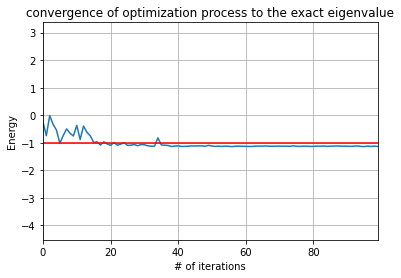

In [84]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [85]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

#### Linear Entangelment

In [86]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

4it [00:00, 10.09it/s]
4it [00:00,  9.56it/s]
4it [00:00, 10.51it/s]
4it [00:00,  8.63it/s]
4it [00:00,  8.55it/s]
4it [00:00,  8.91it/s]
4it [00:00,  7.53it/s]
4it [00:00, 10.90it/s]
4it [00:00,  8.55it/s]
4it [00:00,  8.14it/s]
4it [00:00,  9.83it/s]
4it [00:00, 10.65it/s]
4it [00:00, 10.41it/s]
4it [00:00,  9.87it/s]
4it [00:00, 10.61it/s]
4it [00:00, 14.16it/s]
4it [00:00,  9.39it/s]
4it [00:00, 12.80it/s]
4it [00:00,  8.75it/s]
4it [00:00,  9.99it/s]
4it [00:00, 10.79it/s]
4it [00:00, 11.87it/s]
4it [00:00, 10.02it/s]
4it [00:00, 11.24it/s]
4it [00:00, 11.20it/s]
4it [00:00,  9.07it/s]
4it [00:00, 10.71it/s]
4it [00:00, 11.26it/s]
4it [00:00, 12.46it/s]
4it [00:00, 10.80it/s]
4it [00:00, 10.41it/s]
4it [00:00, 10.59it/s]
4it [00:00, 10.91it/s]
4it [00:00,  9.95it/s]
4it [00:00, 12.76it/s]
4it [00:00,  9.68it/s]
4it [00:00,  8.39it/s]
4it [00:00, 12.16it/s]
4it [00:00, 11.94it/s]
4it [00:00,  9.24it/s]
4it [00:00,  8.80it/s]
4it [00:00, 12.19it/s]
4it [00:00,  9.47it/s]
4it [00:00,

[ 26.78505374   5.25018302 290.0371752  121.28870131 345.32987212
 244.02032157 254.61633068 107.39143118 278.44231133 305.844622
  83.94695803  36.65370495  77.82713879   1.03794262 240.73134575
 342.07819503]


4it [00:00,  6.91it/s]

CPU times: total: 25.7 s
Wall time: 44.3 s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.9789099570788657

Approximation Error
0.026063648443586124


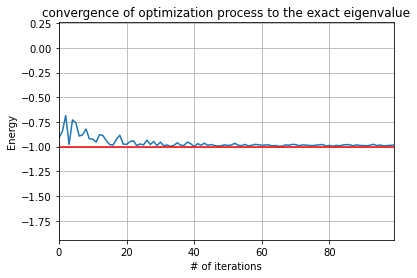

In [87]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [88]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

4it [00:00,  7.73it/s]
4it [00:00,  8.01it/s]
4it [00:00, 10.30it/s]
4it [00:00, 10.32it/s]
4it [00:00,  7.40it/s]
4it [00:00,  9.51it/s]
4it [00:00, 11.19it/s]
4it [00:00,  6.91it/s]
4it [00:00,  8.16it/s]
4it [00:00,  8.12it/s]
4it [00:00,  9.35it/s]
4it [00:00,  8.51it/s]
4it [00:00, 11.46it/s]
4it [00:00,  7.50it/s]
4it [00:00, 11.64it/s]
4it [00:00, 10.24it/s]
4it [00:00,  8.47it/s]
4it [00:00,  9.70it/s]
4it [00:00, 12.95it/s]
4it [00:00, 11.34it/s]
4it [00:00, 10.53it/s]
4it [00:00, 10.06it/s]
4it [00:00, 13.89it/s]
4it [00:00,  8.20it/s]
4it [00:00, 11.23it/s]
4it [00:00, 10.81it/s]
4it [00:00,  7.97it/s]
4it [00:00, 11.05it/s]
4it [00:00,  8.32it/s]
4it [00:00, 12.24it/s]
4it [00:00,  7.55it/s]
4it [00:00, 11.02it/s]
4it [00:00, 12.01it/s]
4it [00:00, 10.03it/s]
4it [00:00, 10.23it/s]
4it [00:00, 10.77it/s]
4it [00:00, 11.32it/s]
4it [00:00,  9.86it/s]
4it [00:00, 10.32it/s]
4it [00:00, 12.49it/s]
4it [00:00, 10.17it/s]
4it [00:00,  8.74it/s]
4it [00:00, 10.84it/s]
4it [00:00,

[201.31875223  22.90586277  77.09571298 146.4006812  243.00581552
 260.37220037 114.96747778 218.18346806 175.08103954  62.95544619
 231.18714827 357.57406839 253.33451631 239.55555062  93.39570546
 281.64848035]


4it [00:00, 10.57it/s]

CPU times: total: 25.4 s
Wall time: 45.5 s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-1.0027862844292117

Approximation Error
0.0023086309570400205


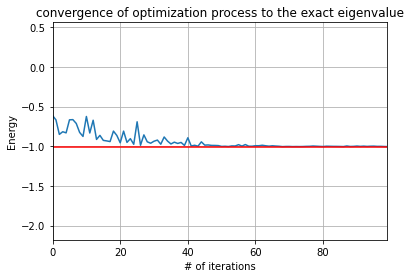

In [89]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)